<a href="https://colab.research.google.com/github/HieuQCao/Machine-Learning-with-Finance/blob/main/Recurrent_Nerual_Network_with_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [111]:
df = yf.Ticker("MSFT")
df = df.history(start="2000-01-02",end="2023-01-01")

df.reset_index(inplace=True)
df.reset_index(drop=True,inplace=True)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 00:00:00-05:00,36.316978,36.703740,34.653900,36.065582,53228400,0.0,0.0
1,2000-01-04 00:00:00-05:00,35.137331,36.239603,34.731231,34.847260,54119000,0.0,0.0
2,2000-01-05 00:00:00-05:00,34.383149,36.007550,33.841682,35.214687,64059600,0.0,0.0
3,2000-01-06 00:00:00-05:00,34.711906,35.234035,33.532281,34.035072,54976600,0.0,0.0
4,2000-01-07 00:00:00-05:00,33.609628,34.731239,33.203528,34.479843,62013600,0.0,0.0
...,...,...,...,...,...,...,...,...
5782,2022-12-23 00:00:00-05:00,233.602848,236.333535,231.455892,236.195023,21207000,0.0,0.0
5783,2022-12-27 00:00:00-05:00,236.165346,236.392900,233.325827,234.443832,16688600,0.0,0.0
5784,2022-12-28 00:00:00-05:00,234.374568,237.174519,231.683449,232.039627,17457100,0.0,0.0
5785,2022-12-29 00:00:00-05:00,233.147736,239.351162,233.147736,238.450821,19770700,0.0,0.0


In [112]:
df = df[['Date', 'Close']]

In [113]:
df['Pct Change']=df['Close'].pct_change(1)*100
df

<ipython-input-113-13e8a3d654ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pct Change']=df['Close'].pct_change(1)*100


,Date,Close,Pct Change
0,2000-01-03 00:00:00-05:00,36.065582,NaN
1,2000-01-04 00:00:00-05:00,34.847260,-3.378076
2,2000-01-05 00:00:00-05:00,35.214687,1.054395
3,2000-01-06 00:00:00-05:00,34.035072,-3.349781
4,2000-01-07 00:00:00-05:00,34.479843,1.306801
...,...,...,...
5782,2022-12-23 00:00:00-05:00,236.195023,0.226712
5783,2022-12-27 00:00:00-05:00,234.443832,-0.741417
5784,2022-12-28 00:00:00-05:00,232.039627,-1.025493
5785,2022-12-29 00:00:00-05:00,238.450821,2.762974


In [114]:
df.index = df.pop('Date')

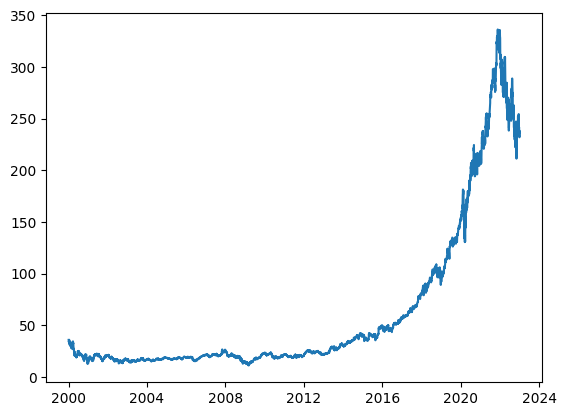

In [115]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [116]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [135]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str,subset, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset[subset].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
number_past=10
windowed_df = df_to_windowed_df(df,
                                '2011-03-25',
                                '2022-03-23','Pct Change',
                                n=number_past)
windowed_df

<ipython-input-135-114da8b88856>:14: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df_subset = dataframe.loc[:target_date].tail(n+1)
<ipython-input-135-114da8b88856>:27: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]


,Target Date,Target-10,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2011-03-25,1.062622,0.038904,-1.167734,-2.363139,-0.040370,0.080722,2.137094,-0.118459,0.948681,1.057106,-0.736102
1,2011-03-28,0.038904,-1.167734,-2.363139,-0.040370,0.080722,2.137094,-0.118459,0.948681,1.057106,-0.736102,-0.819722
2,2011-03-29,-1.167734,-2.363139,-0.040370,0.080722,2.137094,-0.118459,0.948681,1.057106,-0.736102,-0.819722,0.314874
3,2011-03-30,-2.363139,-0.040370,0.080722,2.137094,-0.118459,0.948681,1.057106,-0.736102,-0.819722,0.314874,0.470766
4,2011-03-31,-0.040370,0.080722,2.137094,-0.118459,0.948681,1.057106,-0.736102,-0.819722,0.314874,0.470766,-0.859024
...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2022-03-17,-1.422452,-2.047839,-3.777683,-1.097121,4.585807,-1.008657,-1.932852,-1.296089,3.874261,2.521308,0.281960
2764,2022-03-18,-2.047839,-3.777683,-1.097121,4.585807,-1.008657,-1.932852,-1.296089,3.874261,2.521308,0.281960,1.764780
2765,2022-03-21,-3.777683,-1.097121,4.585807,-1.008657,-1.932852,-1.296089,3.874261,2.521308,0.281960,1.764780,-0.422721
2766,2022-03-22,-1.097121,4.585807,-1.008657,-1.932852,-1.296089,3.874261,2.521308,0.281960,1.764780,-0.422721,1.637899


In [118]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2768,), (2768, 10, 1), (2768,))

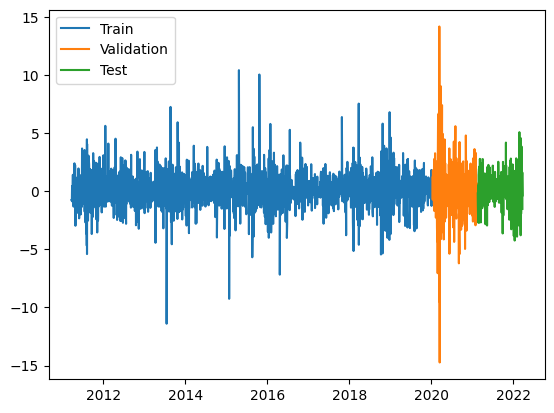

In [119]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((number_past, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
70/70 [==============================] - 4s 17ms/step - loss: 2.0769 - mean_absolute_error: 1.0058 - val_loss: 7.1126 - val_mean_absolute_error: 1.7904
Epoch 2/100
70/70 [==============================] - 1s 9ms/step - loss: 2.0612 - mean_absolute_error: 1.0057 - val_loss: 7.0562 - val_mean_absolute_error: 1.7865
Epoch 3/100
70/70 [==============================] - 1s 8ms/step - loss: 2.0574 - mean_absolute_error: 1.0051 - val_loss: 7.0196 - val_mean_absolute_error: 1.7824
Epoch 4/100
70/70 [==============================] - 1s 9ms/step - loss: 2.0546 - mean_absolute_error: 1.0048 - val_loss: 7.0485 - val_mean_absolute_error: 1.7882
Epoch 5/100
70/70 [==============================] - 1s 9ms/step - loss: 2.0532 - mean_absolute_error: 1.0046 - val_loss: 6.9836 - val_mean_absolute_error: 1.7784
Epoch 6/100
70/70 [==============================] - 1s 9ms/step - loss: 2.0502 - mean_absolute_error: 1.0046 - val_loss: 6.9762 - val_mean_absolute_error: 1.7840
Epoch 7/100
70/70 [==

70/70 [==============================] - 1s 4ms/step


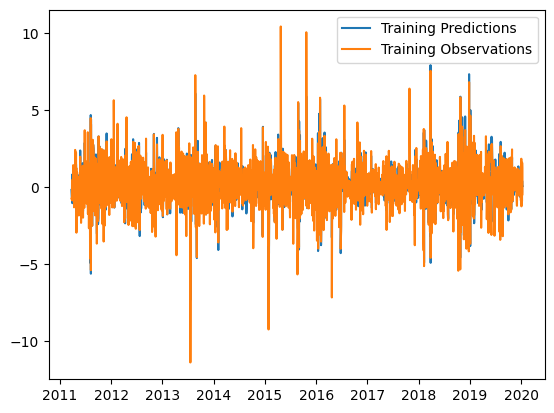

In [121]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

9/9 [==============================] - 0s 4ms/step


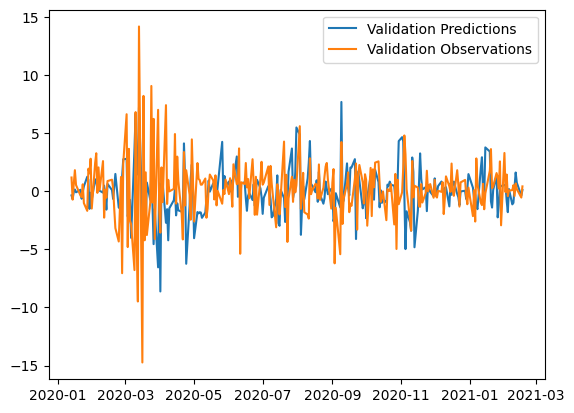

In [122]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

9/9 [==============================] - 0s 4ms/step


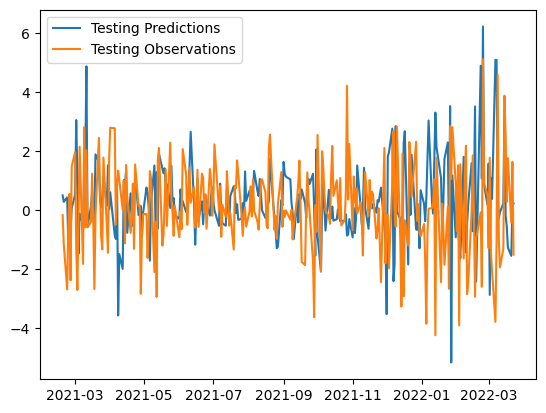

In [123]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [136]:
close_df = df_to_windowed_df(df,
                                '2011-03-25',
                                '2022-03-23','Close',
                                1)
close_df=close_df[q_90:]
close_df

<ipython-input-135-114da8b88856>:14: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df_subset = dataframe.loc[:target_date].tail(n+1)
<ipython-input-135-114da8b88856>:27: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]


,Target Date,Target-1,Target
2491,2021-02-18,237.921051,237.521561
2492,2021-02-19,237.521561,234.774094
2493,2021-02-22,234.774094,228.480179
2494,2021-02-23,228.480179,227.272049
2495,2021-02-24,227.272049,228.519150
...,...,...,...
2763,2022-03-17,289.156769,289.972076
2764,2022-03-18,289.972076,295.089447
2765,2022-03-21,295.089447,293.842041
2766,2022-03-22,293.842041,298.654877


In [132]:
len(test_predictions)

277

In [139]:
close_df['Predicted Price']=close_df['Target']*(1+test_predictions/100)
close_df

,Target Date,Target-1,Target,Predicted Price
2491,2021-02-18,237.921051,237.521561,238.713301
2492,2021-02-19,237.521561,234.774094,235.444892
2493,2021-02-22,234.774094,228.480179,229.470814
2494,2021-02-23,228.480179,227.272049,224.505968
2495,2021-02-24,227.272049,228.519150,227.250590
...,...,...,...,...
2763,2022-03-17,289.156769,289.972076,288.402321
2764,2022-03-18,289.972076,295.089447,291.371319
2765,2022-03-21,295.089447,293.842041,289.305211
2766,2022-03-22,293.842041,298.654877,298.986122


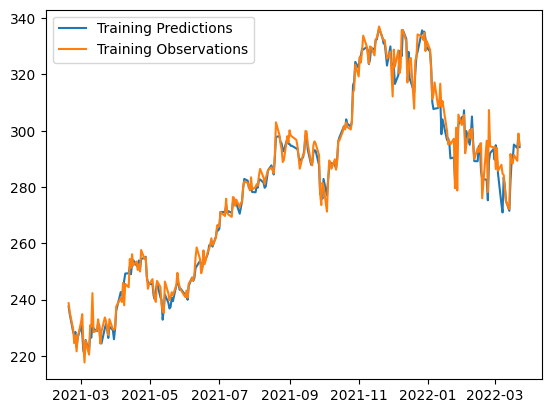

In [141]:
plt.plot(dates_test, close_df['Target'])
plt.plot(dates_test, close_df['Predicted Price'])
plt.legend(['Training Predictions', 'Training Observations'])

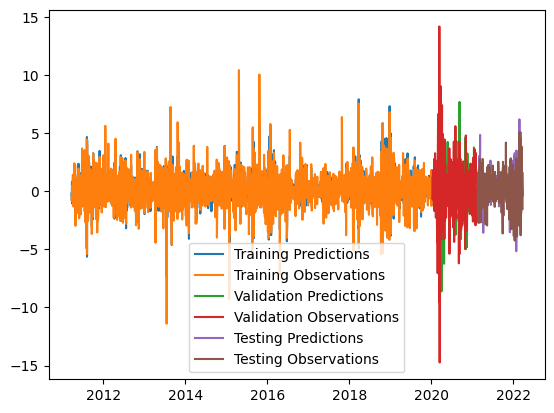

In [124]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [125]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 24ms/step


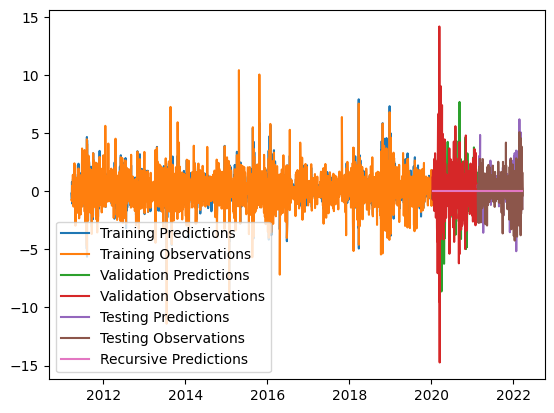

In [127]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])